In this file, will explore how to find the "brightness histogram" for each type of MRI. We are looking for clear humps that can make up a decent GMM model

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from dipy.io.image import load_nifti
import pandas as pd
import sklearn.cluster

# Load data

In [2]:
sample_flair_path = "../../lib/BraTS_2018/LGG/Brats18_2013_0_1/Brats18_2013_0_1_flair.nii"
sample_seg_path = "../../lib/BraTS_2018/LGG/Brats18_2013_0_1/Brats18_2013_0_1_seg.nii"
sample_T1_path = "../../lib/BraTS_2018/LGG/Brats18_2013_0_1/Brats18_2013_0_1_t1.nii"
sample_T1g_path = "../../lib/BraTS_2018/LGG/Brats18_2013_0_1/Brats18_2013_0_1_t1ce.nii"
sample_T2_path = "../../lib/BraTS_2018/LGG/Brats18_2013_0_1/Brats18_2013_0_1_t2.nii"

In [3]:
data_flair, affine, im = load_nifti(sample_flair_path, return_img=True)

In [4]:
#FOR NOW, CAST AS ARRAY OF INTS (PROBABLY WANT FLOAT32 EVENTUALLY)
data_flair=data_flair.astype(np.float32)
#normalize
data_flair=data_flair/np.max(data_flair)
#take log
data_flair_log =np.exp(data_flair+1e-6)

In [5]:
data_seg, affine, im = load_nifti(sample_seg_path, return_img=True)
data_seg=data_seg.astype(np.int)


# FLAIR histogram
Want 4 humps: background, grey matter, white matter, tumor

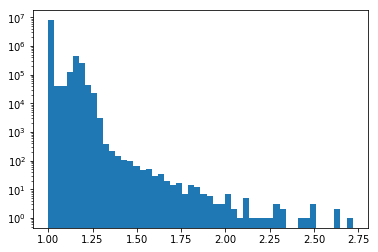

In [6]:
flair_flat = data_flair_log.flatten()
plt.figure()
plt.hist(flair_flat, bins=50, log=True)
plt.show()

In [7]:
flair_2D = flair_flat.reshape(len(flair_flat), 1) #kmeans needs 2d (vertical) matrix where each row is a datapoint
flair_kmeans = sklearn.cluster.KMeans(n_clusters=6, random_state=0).fit_predict(flair_2D)

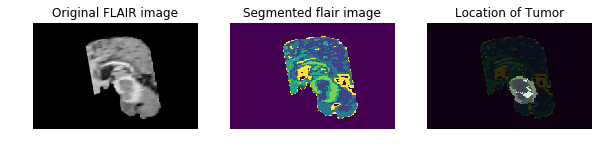

In [67]:
flair_kmeans_brain = flair_kmeans.reshape(240, 240, 155)
plt.figure(figsize=(10,5))

plt.subplot(1,3,1).set_axis_off()
plt.title("Original FLAIR image")
plt.imshow(data_flair[120,:,:].T, cmap="gray", origin='lower')

plt.subplot(1,3,2).set_axis_off()
plt.title("Segmented flair image")
plt.imshow(flair_kmeans_brain[120,:,:].T,  origin='lower')

plt.subplot(1,3,3).set_axis_off()
plt.title("Location of Tumor")
plt.imshow(flair_kmeans_brain[120,:,:].T, origin='lower')
plt.imshow(data_seg[120,:,:].T, alpha=0.8, cmap="gray", origin='lower')
plt.show()

In [9]:
np.unique(data_seg.flatten())

array([0, 1, 2, 4])

# Test accuracy of FLAIR segmentation
-not bad!

In [10]:
np.unique(flair_kmeans)

array([0, 1, 2, 3, 4, 5], dtype=int32)

Since tumor is brightest spot, likely has value 3

True tumor coordinates

In [49]:
y_coors = np.argwhere(data_seg.flatten()!=0)

In [50]:
tumor_size=len(y_coors)
tumor_size

49924

Predicted tumor coordinates - not brightest spot

In [59]:
flair_yhat_coors = np.argwhere(flair_kmeans ==4)

# True positive

In [60]:
correct_id_tumor = np.intersect1d(y_coors, flair_yhat_coors, assume_unique=True)
len(correct_id_tumor)

20958

In [61]:
percent_tumor_correct = len(correct_id_tumor)/tumor_size
percent_tumor_correct

0.4197980931015143

### False positive

In [62]:
false_positive_points = np.setdiff1d(flair_yhat_coors, y_coors, assume_unique=True)
len(false_positive_points)

21580

In [63]:
false_positive = len(false_positive_points)/len(data_seg.flatten())
false_positive

0.002417114695340502

### False Negative

In [64]:
false_neg_points = np.setdiff1d(y_coors, flair_yhat_coors, assume_unique=True)

In [65]:
false_neg = len(false_neg_points)/len(data_seg.flatten())
false_neg

0.003244399641577061

### True negative

In [66]:
true_negative=1-(tumor_size+len(false_positive_points))/len(data_seg.flatten())
true_negative

0.9919910394265233

### Total misidentification

In [21]:
total_incorrect_points = np.concatenate((false_neg_points, false_positive_points))

In [22]:
total_error = len(total_incorrect_points)/len(data_seg.flatten())
total_error

0.013727374551971327